# Anomalous diffraction theory

We do some comparisons with results from Anomalous Diffraction Theory.  The formulas used below are from Moosmüller and Sorensen [Single scattering albedo of homogeneous, spherical particles in the transition regime](https://doi.org/10.1016/j.jqsrt.2018.08.015)  The results match those shown in their paper.

**Scott Prahl**

**May 2024**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import miepython
%config InlineBackend.figure_format = 'retina'

## Approximations

First thing is to define some reasonably accurate approximations for the efficiencies for large spheres.  This way we can ensure that the limiting cases behave as they should.

In [2]:
def Qabs_adt(m,x):
    """
    Anomalous diffraction theory approximation for absorption efficiency
    """
    n = m.real
    kappa = abs(m.imag)

    if kappa == 0:
        return np.zeros_like(x)
    return 1+2*np.exp(-4*kappa*x)/(4*kappa*x)+2*(np.exp(-4*kappa*x)-1)/(4*kappa*x)**2

def Qext_adt(m,x):
    """
    Anomalous diffraction theory approximation for extinction efficiency
    """
    n = m.real
    kappa = abs(m.imag)
    rho = 2*x*np.abs(m-1)
    beta = np.arctan2(kappa,n-1)
    ex = np.exp(-rho * np.tan(beta))

    qext_adt = 2
    qext_adt += -4*ex*np.cos(beta)/rho*np.sin(rho-beta)
    qext_adt += -4*ex*np.cos(beta)**2/rho**2*np.cos(rho-2*beta)
    qext_adt += 4*np.cos(beta)**2/rho**2*np.cos(2*beta)
    return qext_adt


def Qabs_madt(m,x):
    """
    Modified anomalous diffraction theory approximation for absorption efficiency
    """
    n = m.real
    kappa = abs(m.imag)

    if kappa == 0:
        return np.zeros_like(x)
    
    qabs_adt = Qabs_adt(m,x)
    epsilon = 0.25 + 0.61*(1-np.exp(-8*np.pi/3*kappa))**2
    c1 = 0.25*(1+np.exp(-1167*kappa))*(1-qabs_adt)
    c2 = np.sqrt(2*epsilon*x/np.pi)*np.exp(0.5-epsilon*x/np.pi)*(0.7393*n-0.6069)
    return (1+c1+c2)*qabs_adt


def Qext_madt(m,x):
    """
    Modified anomalous diffraction theory approximation for extinction efficiency
    """
    n = m.real
    kappa = -np.imag(m)
    
    qext_adt = Qext_adt(m,x)
    epsilon = 0.25 + 0.61*(1-np.exp(-8*np.pi/3*kappa))**2
    c2 = np.sqrt(2*epsilon*x/np.pi)*np.exp(0.5-epsilon*x/np.pi)*(0.7393*n-0.6069)
    Qedge = (1-np.exp(-0.06*x))*x**(-2/3)

    return (1+0.5*c2)*qext_adt+Qedge

## No Absorption Case `m=1.5`

In [3]:
def add_common_plot_stuff(ymax):
    plt.xlabel(r"Size Parameter $2\pi a/\lambda$")
    plt.axvspan(0.1, 1, color='cyan', alpha=0.4)
    plt.text(0.3, 0.95*ymax, 'Rayleigh\nRegime', ha='center', va='top')
    plt.axvspan(1, 100, color='pink', alpha=0.4)
    plt.text(10, 0.95*ymax, 'Transition\nRegime', ha='center', va='top')
    plt.axvspan(100, 100000, color='yellow', alpha=0.4)
    plt.text(3000, 0.95*ymax, 'Geometric\nRegime', ha='center', va='top')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(0.1,100000)
    plt.ylim(0, ymax)
   

In [4]:
m = 1.5
x = np.logspace(-1, 5, 300)  # also in microns
qext, qsca, qback, g = miepython.mie(m,x)
qabs = qext-qsca

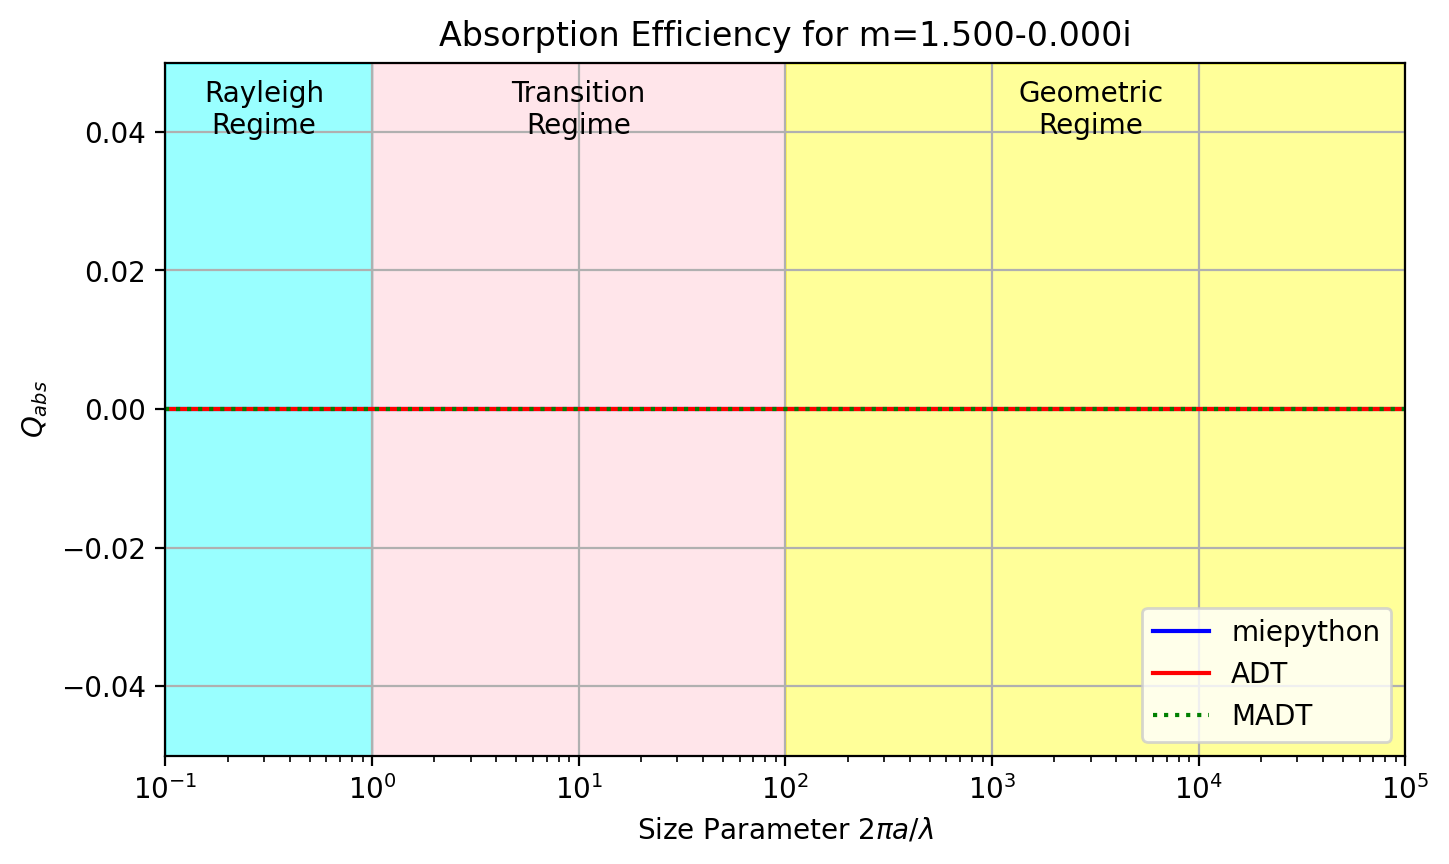

In [5]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, qabs, 'b-', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g:', label="MADT")
plt.ylabel("$Q_{abs}$")
add_common_plot_stuff(0.05)
plt.ylim(-0.05,0.05)
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.show()

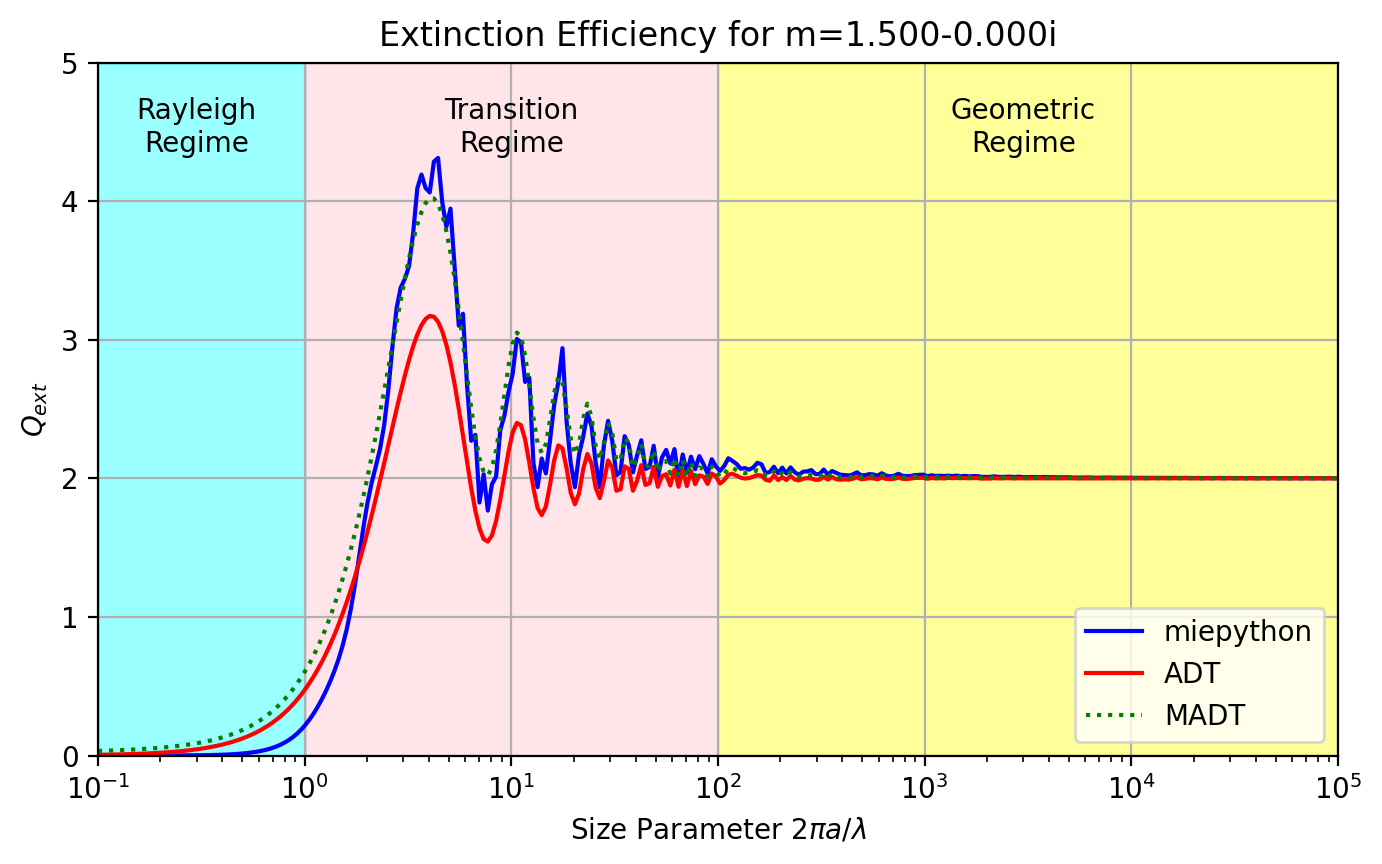

In [6]:
plt.figure(figsize=(8,4.5))
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))

plt.semilogx(x, qext, 'b', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g:', label="MADT")
plt.ylabel("$Q_{ext}$")
add_common_plot_stuff(5)
plt.show()

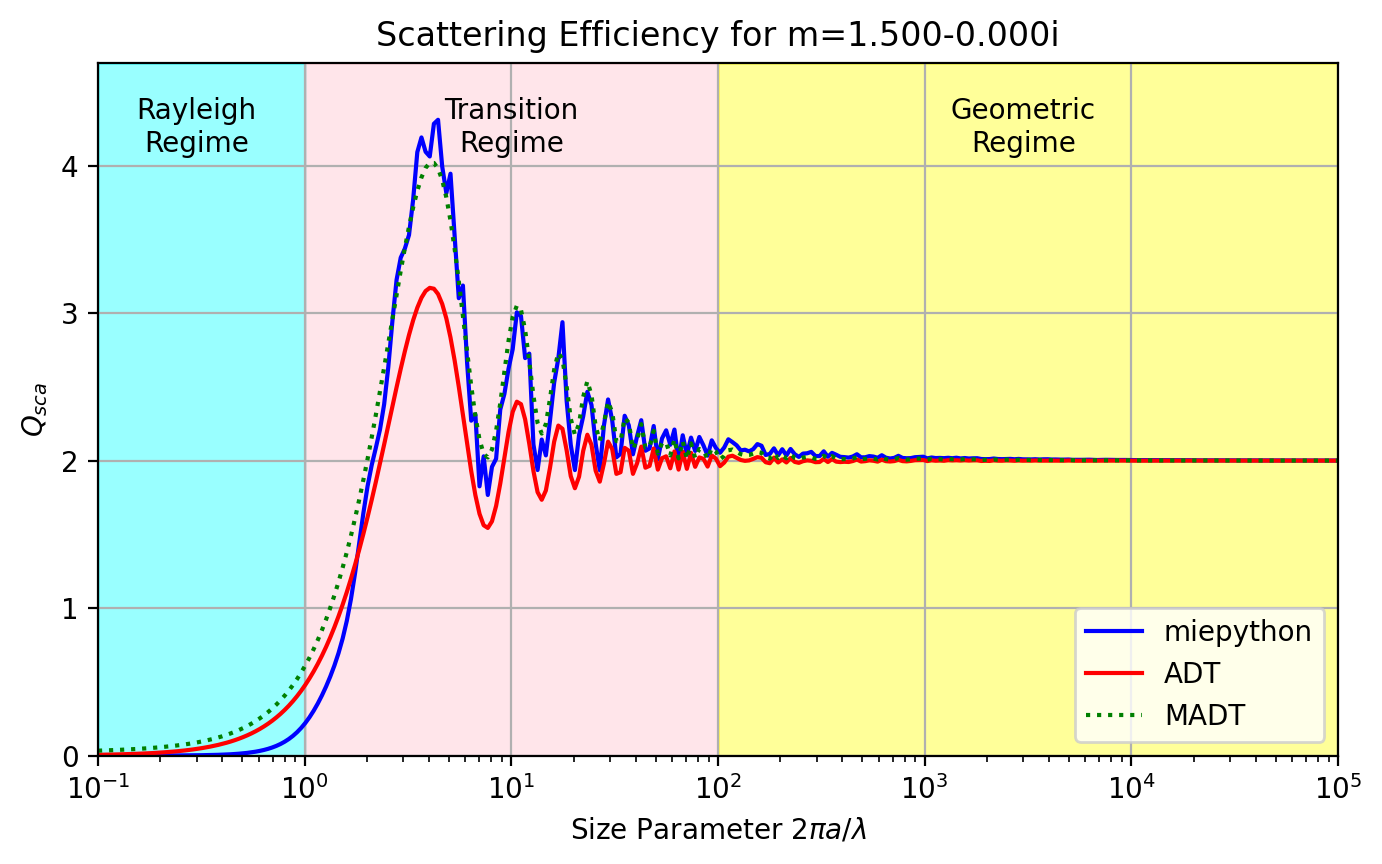

In [7]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.figure(figsize=(8,4.5))
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r', label="ADT")
plt.semilogx(x, Qsca_madt, 'g:', label="MADT")
plt.ylabel("$Q_{sca}$")
add_common_plot_stuff(4.7)

plt.show()

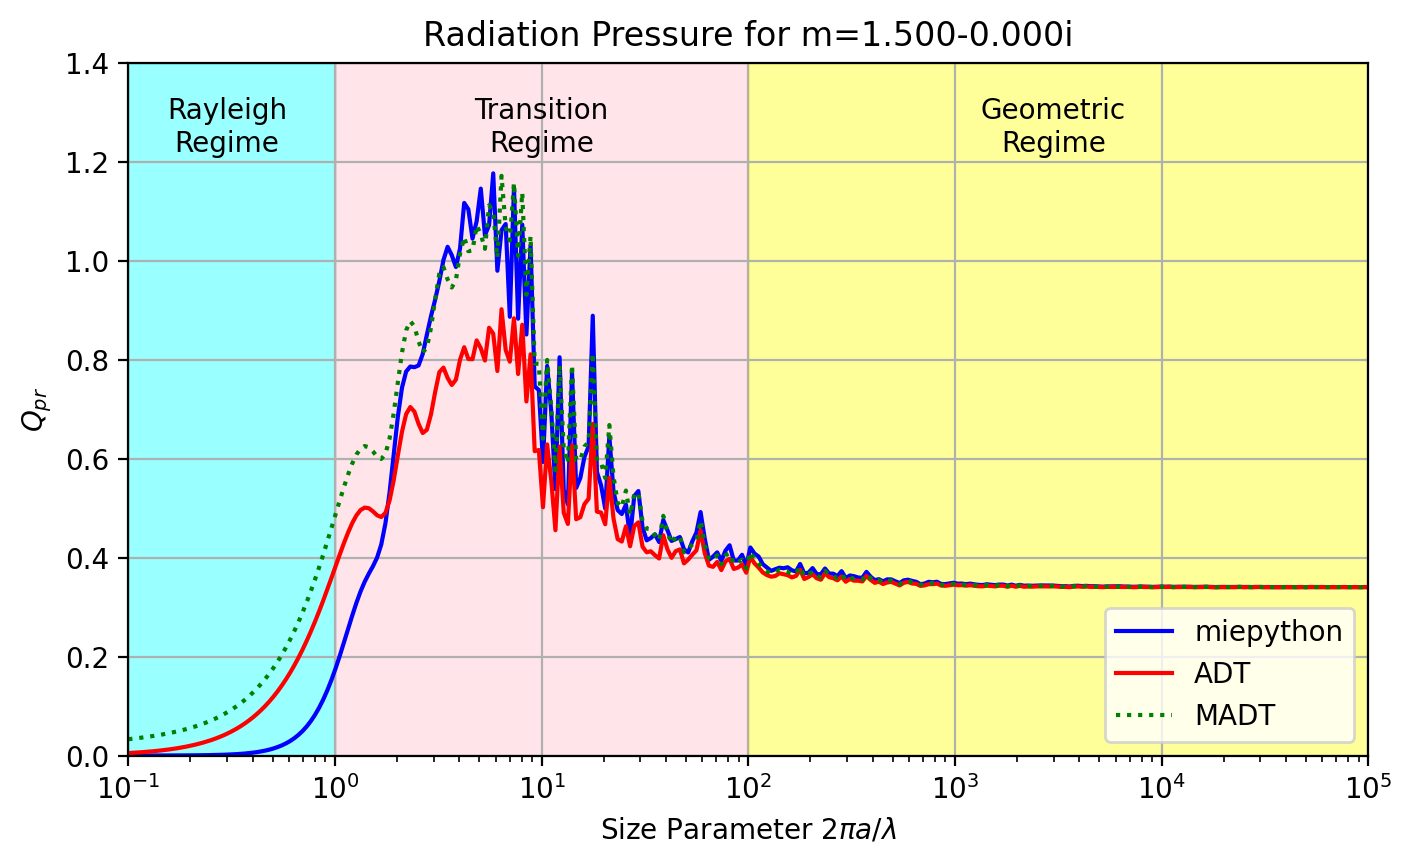

In [8]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.figure(figsize=(8,4.5))
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r', label="ADT")
plt.semilogx(x, Qpr_madt, 'g:', label="MADT")
plt.ylabel("$Q_{pr}$")

add_common_plot_stuff(1.4)
plt.show()

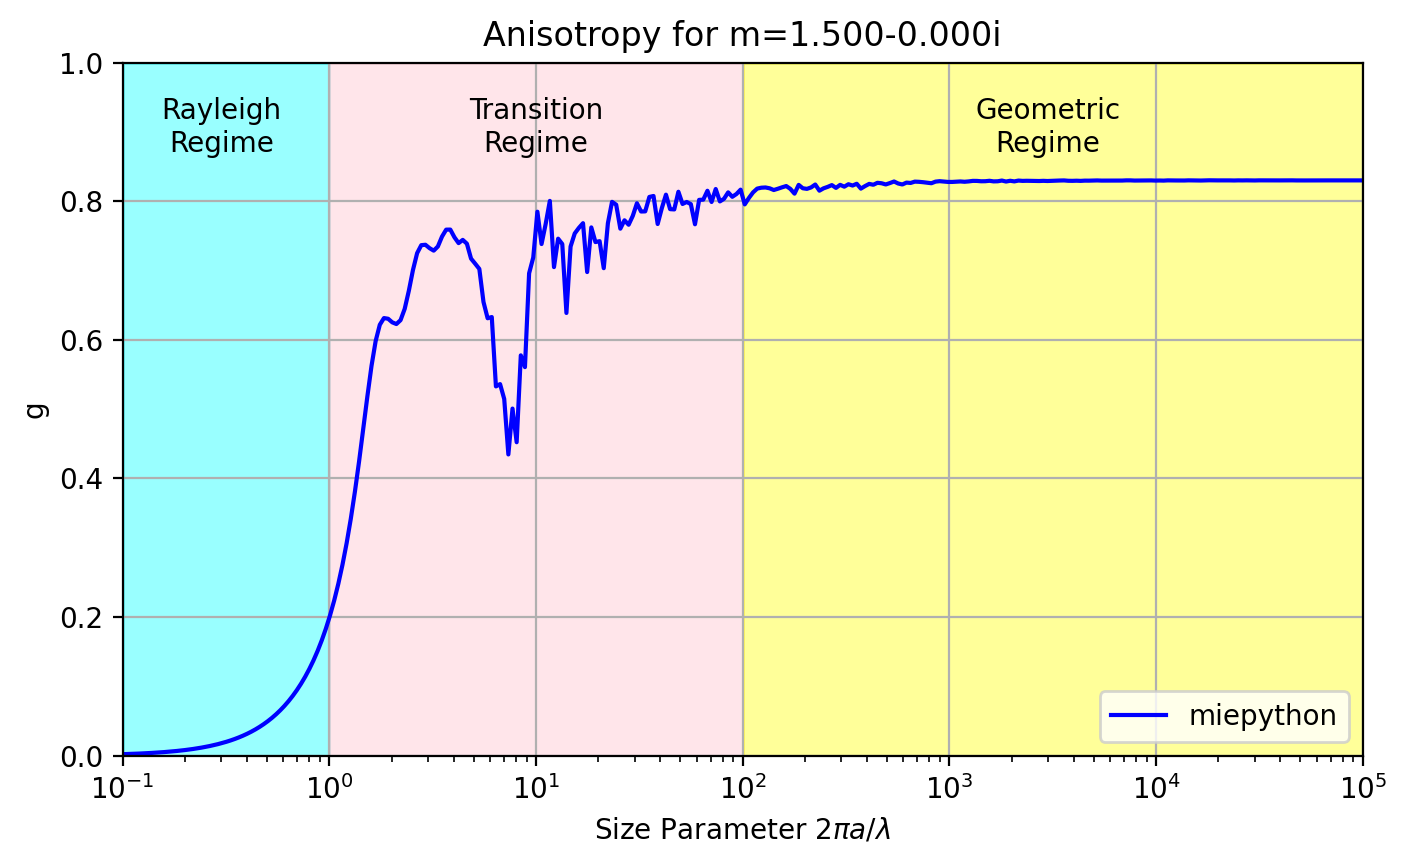

In [9]:
plt.figure(figsize=(8,4.5))
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, g, 'b', label="miepython")
plt.ylabel("g")
add_common_plot_stuff(1.0)

plt.show()

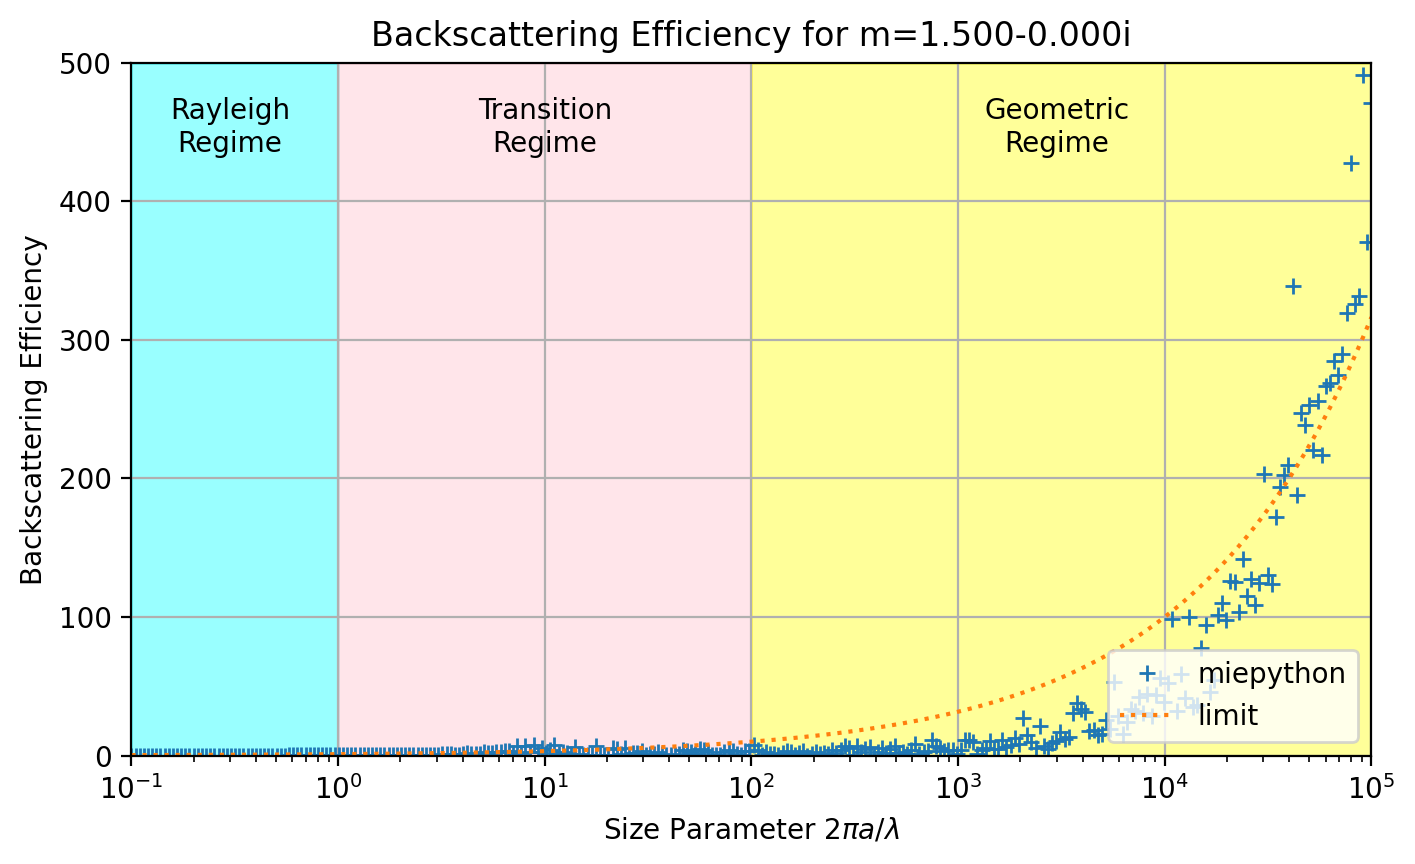

In [10]:
## No absorption means that the argument that the backscatter
## efficiency goes as the surface reflection fails.  See 09_backscatter.ipynb
## for tests that show that miepython correctly calculates qback

plt.figure(figsize=(8,4.5))
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qback, '+', label="miepython")
plt.semilogx(x, x**0.5, ':', label="limit")
plt.ylabel("Backscattering Efficiency")
add_common_plot_stuff(500)

plt.show()

## A little absorption `m=1.5-0.001j`

In [11]:
m = 1.5-0.001j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = miepython.mie(m,x)
qabs = qext-qsca

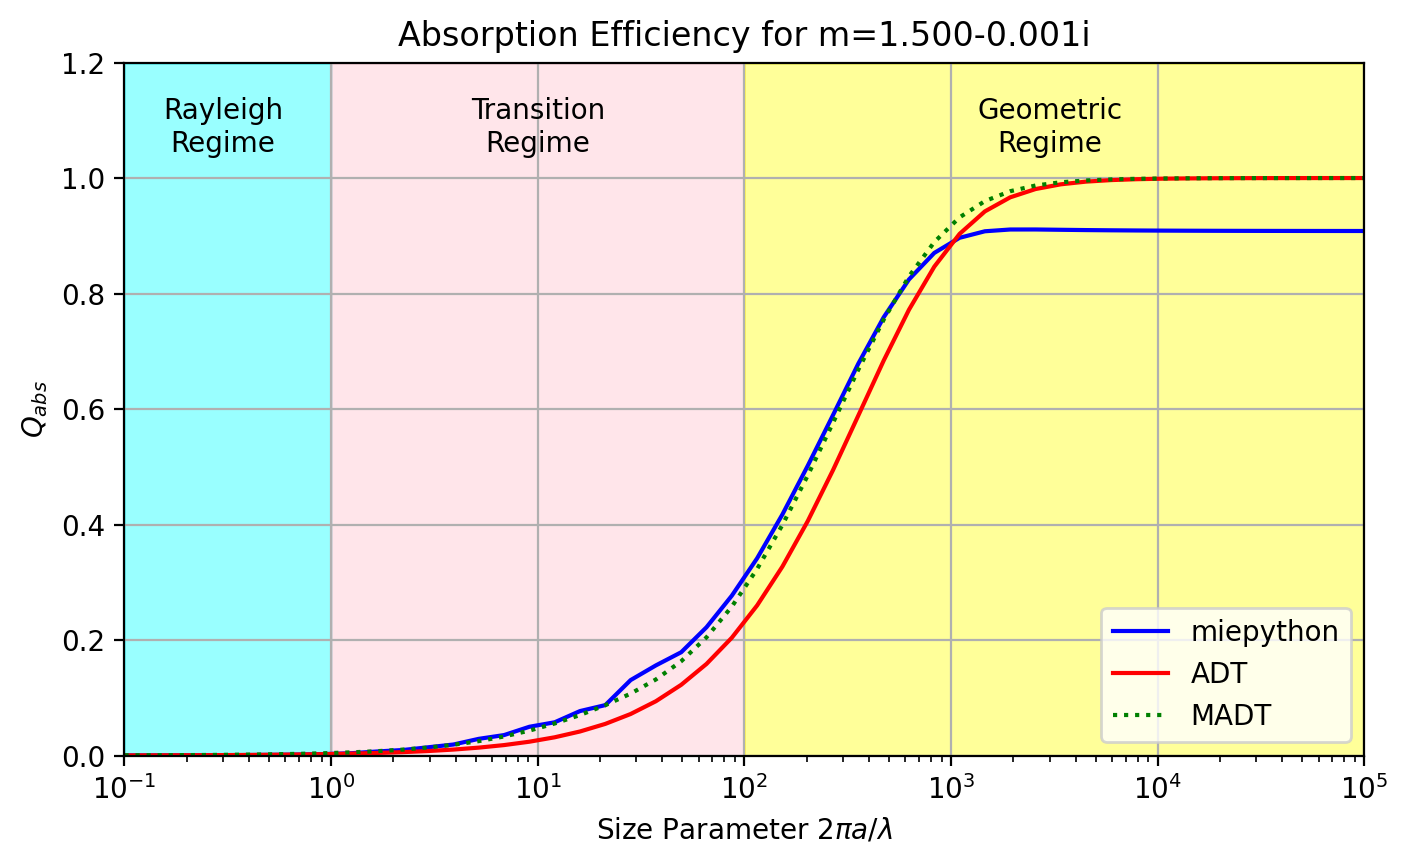

In [12]:
plt.figure(figsize=(8,4.5))
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qabs, 'b', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g:', label="MADT")
plt.ylabel("$Q_{abs}$")
add_common_plot_stuff(1.2)
plt.show()

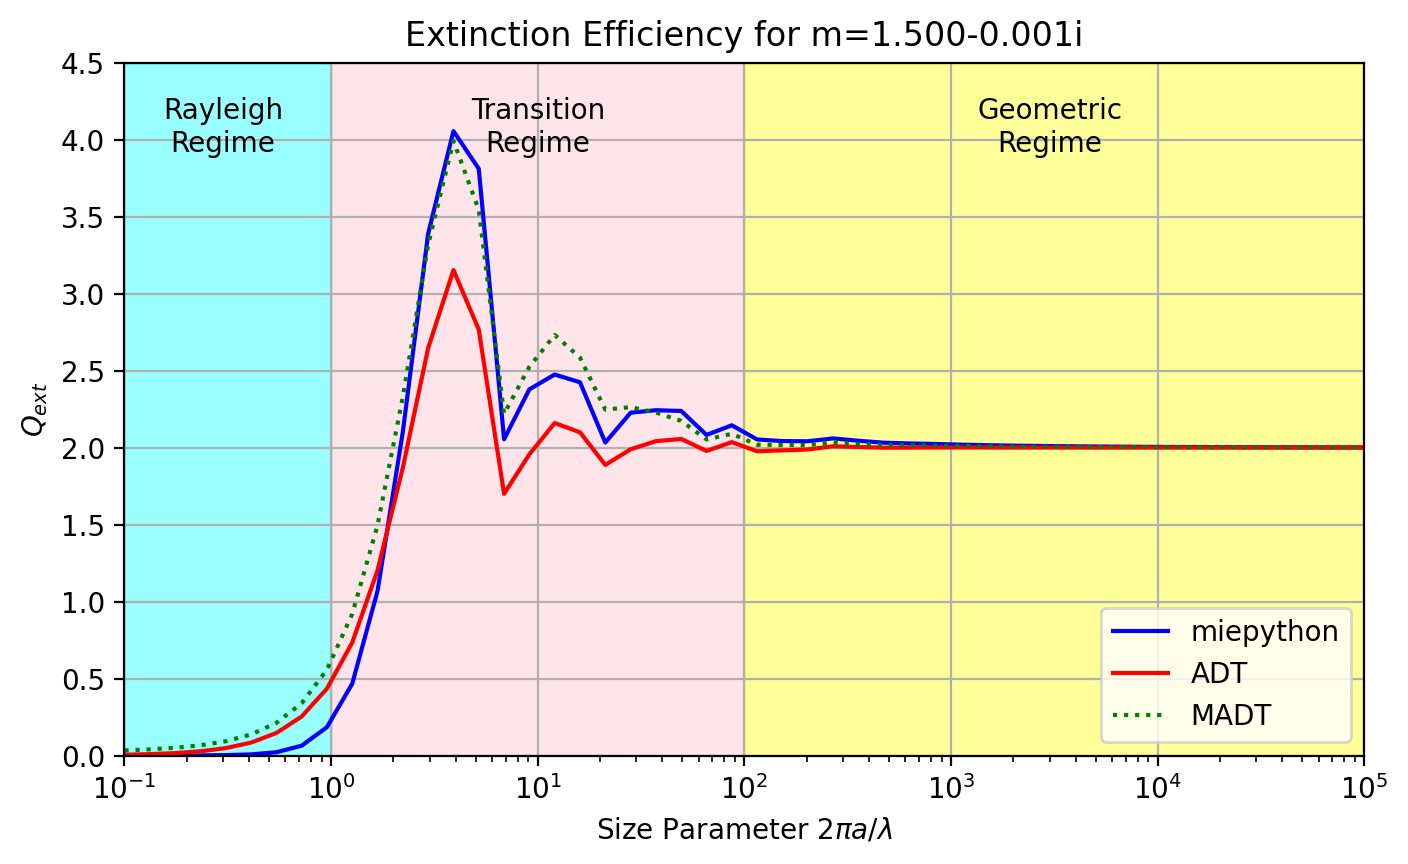

In [13]:
plt.figure(figsize=(8,4.5))
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qext, 'b', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g:', label="MADT")
plt.ylabel("$Q_{ext}$")
add_common_plot_stuff(4.5)
plt.show()

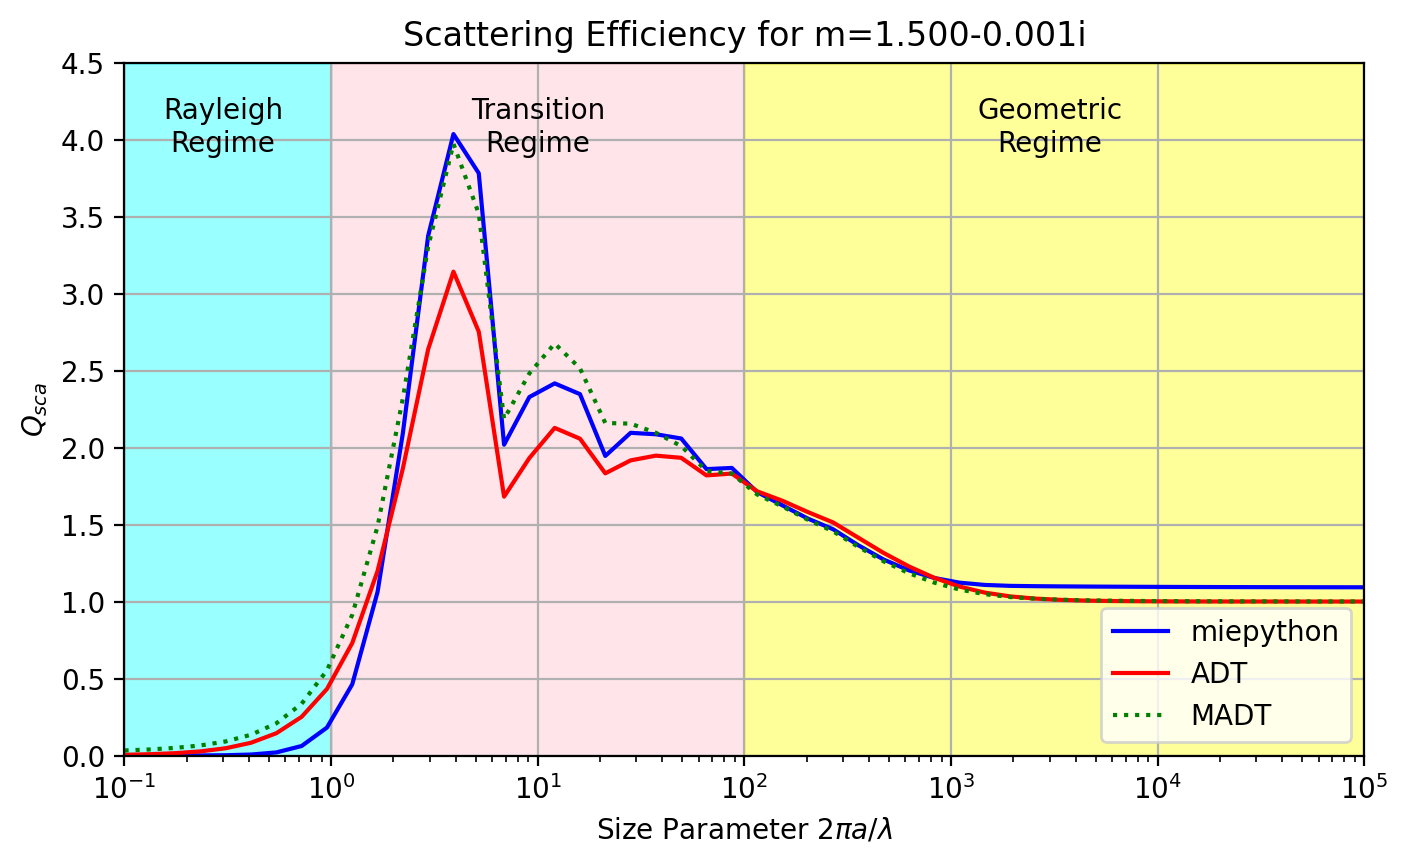

In [14]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.figure(figsize=(8,4.5))
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r', label="ADT")
plt.semilogx(x, Qsca_madt, 'g:', label="MADT")

plt.ylabel("$Q_{sca}$")
add_common_plot_stuff(4.5)
plt.show()

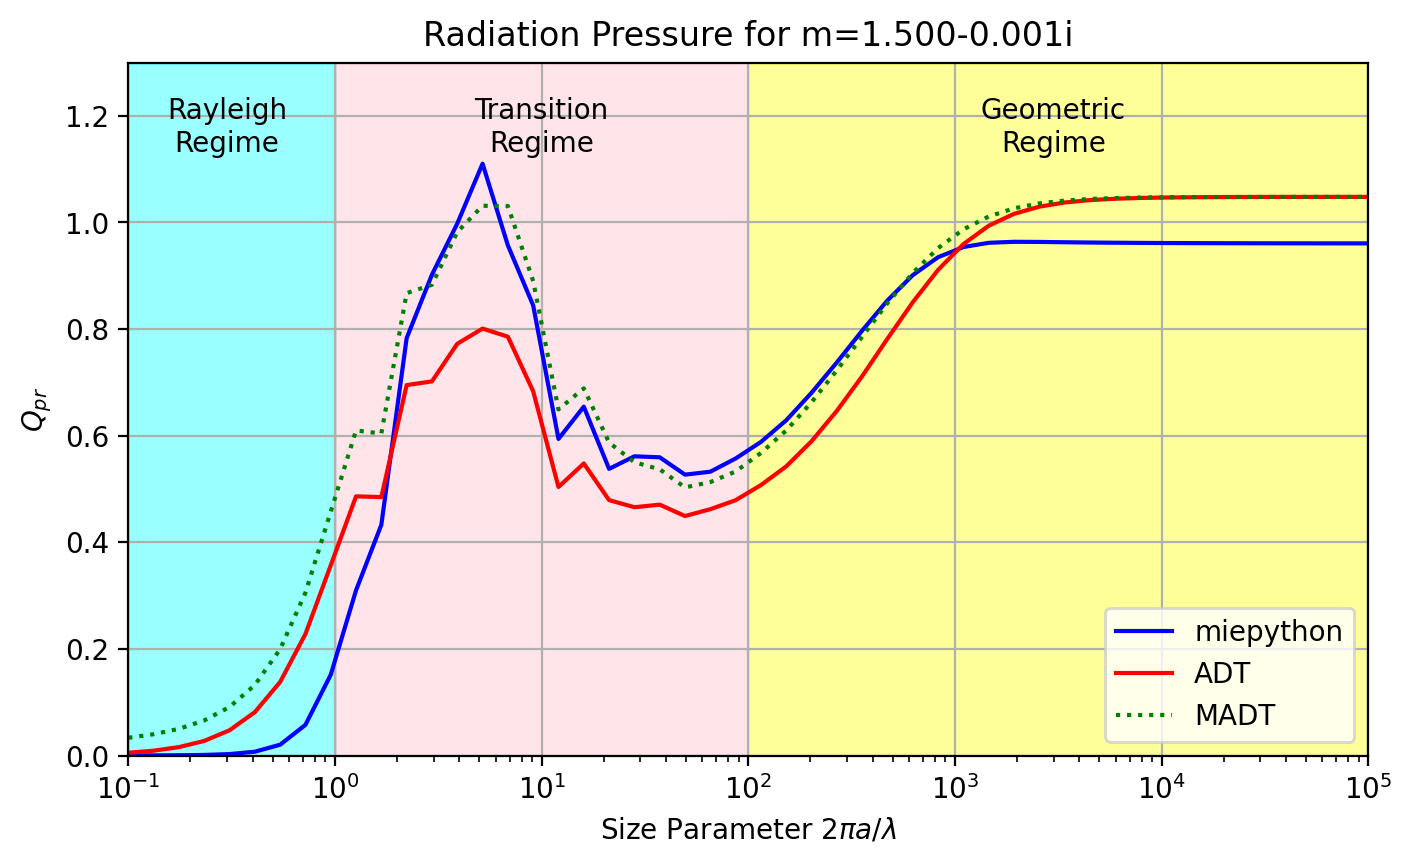

In [15]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.figure(figsize=(8,4.5))
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r', label="ADT")
plt.semilogx(x, Qpr_madt, 'g:', label="MADT")
plt.ylabel("$Q_{pr}$")
add_common_plot_stuff(1.3)
plt.show()

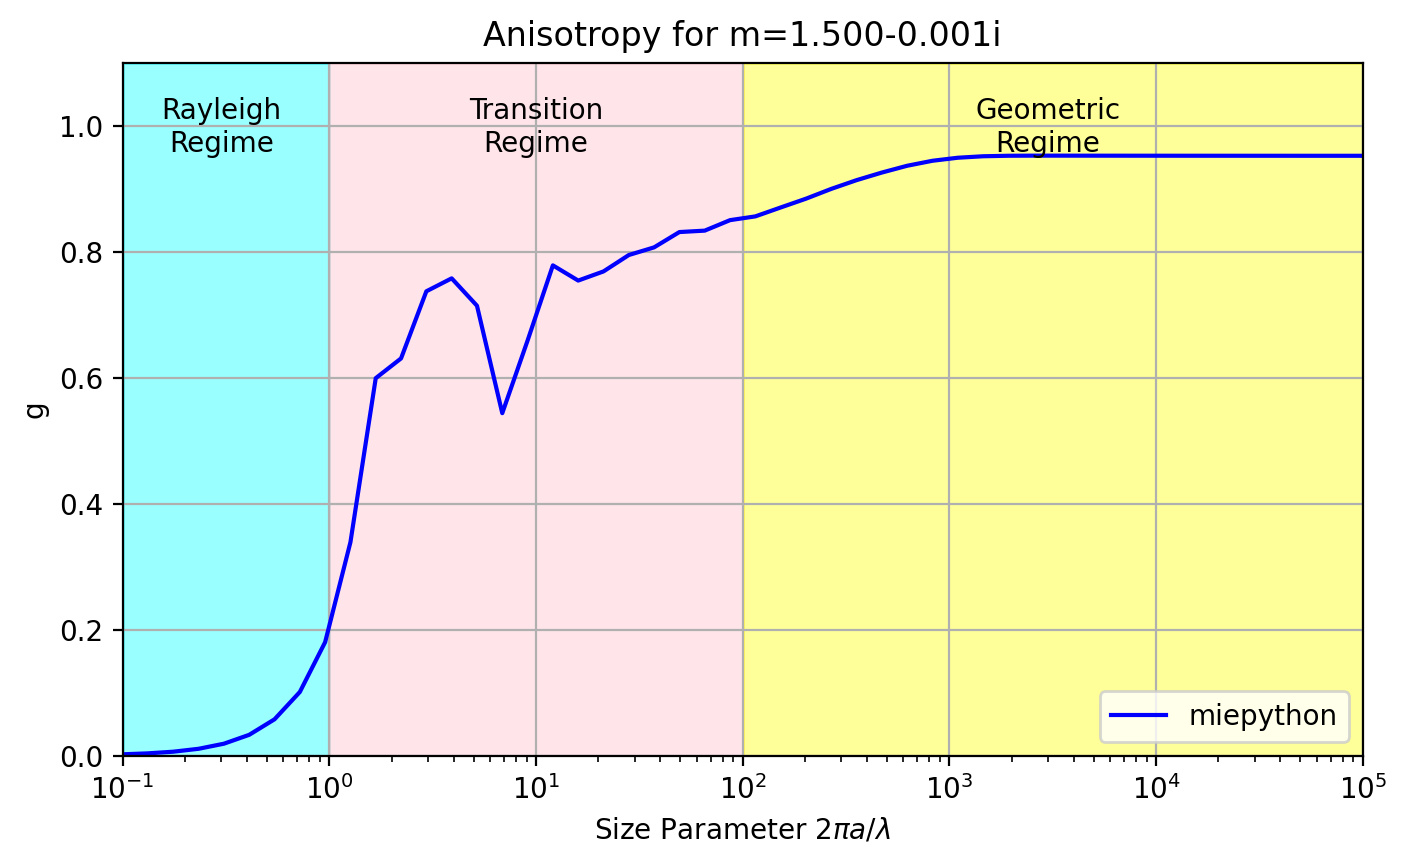

In [16]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, g, 'b', label="miepython")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.1)
plt.show()

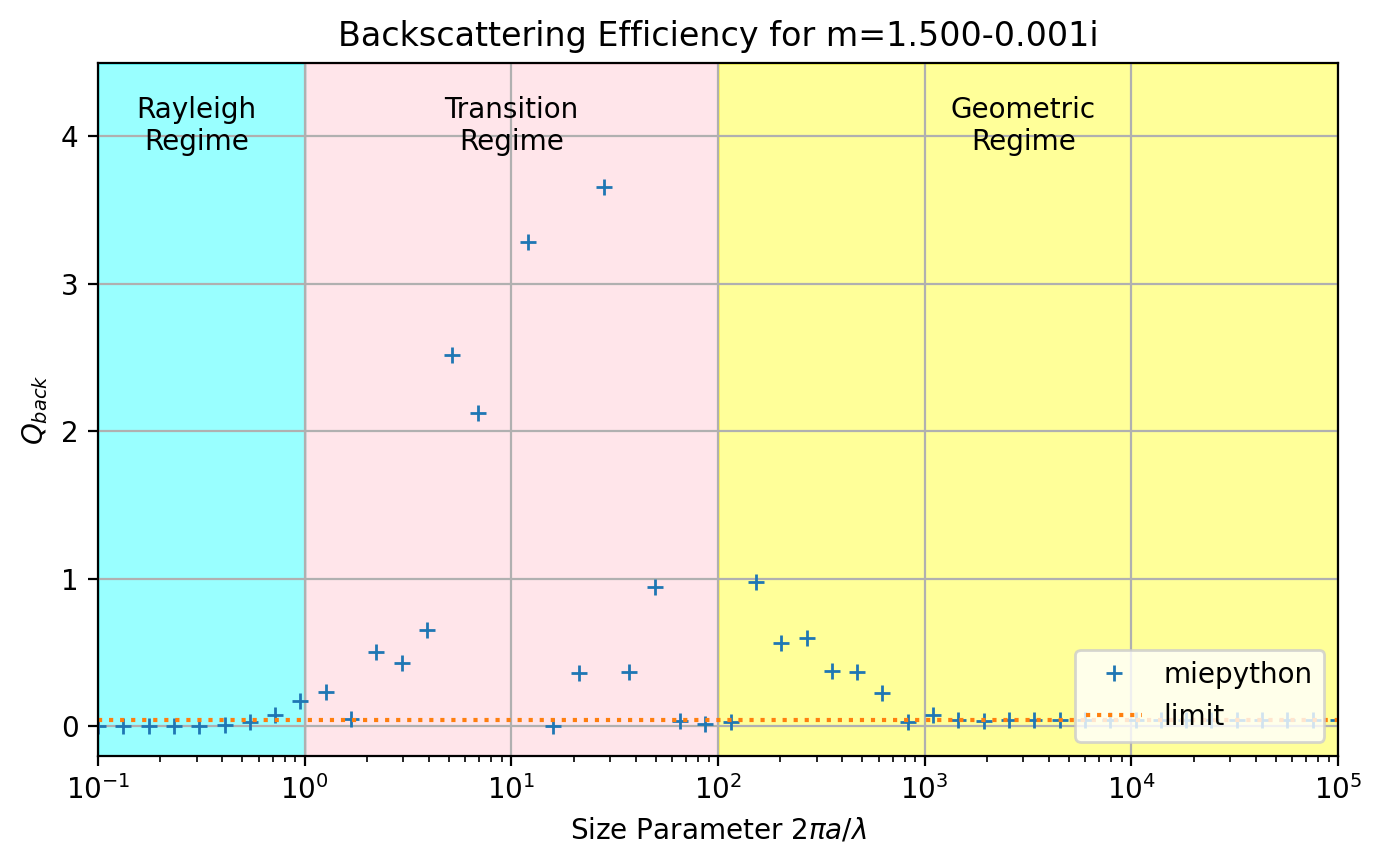

In [17]:
Qbacks = abs(m-1)**2/abs(m+1)**2
Qback = Qbacks * np.ones_like(x)

plt.figure(figsize=(8,4.5))
plt.semilogx(x, qback, '+', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.ylabel("$Q_{back}$")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(4.5)
plt.ylim(-0.2,4.5)
plt.show()

## Some Absorption `m=1.5-0.1j`

In [18]:
m = 1.5-0.1j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = miepython.mie(m,x)
qabs = qext-qsca

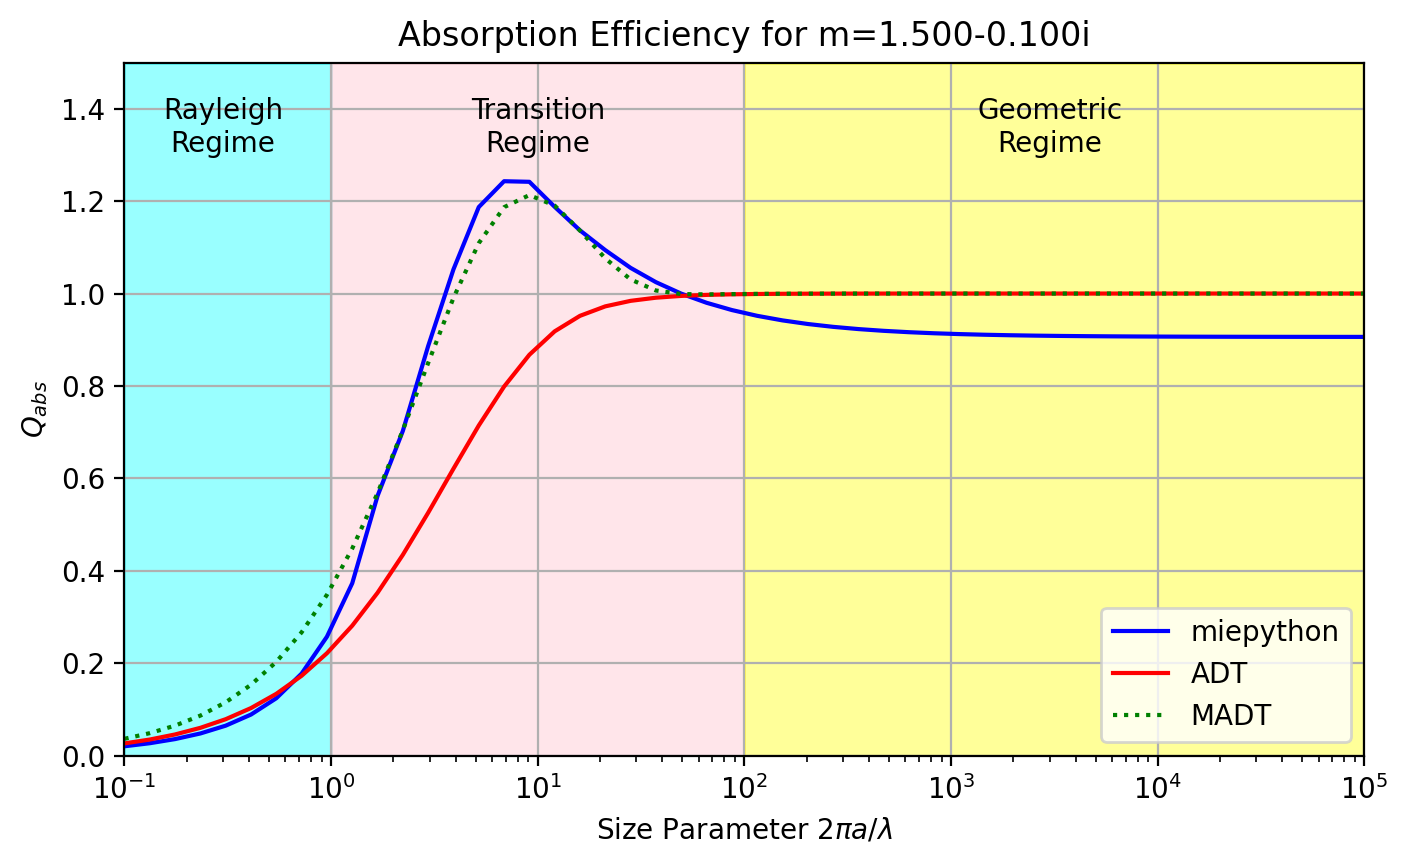

In [19]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, qabs, 'b', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g:', label="MADT")

plt.ylabel("$Q_{abs}$")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.5)
plt.show()

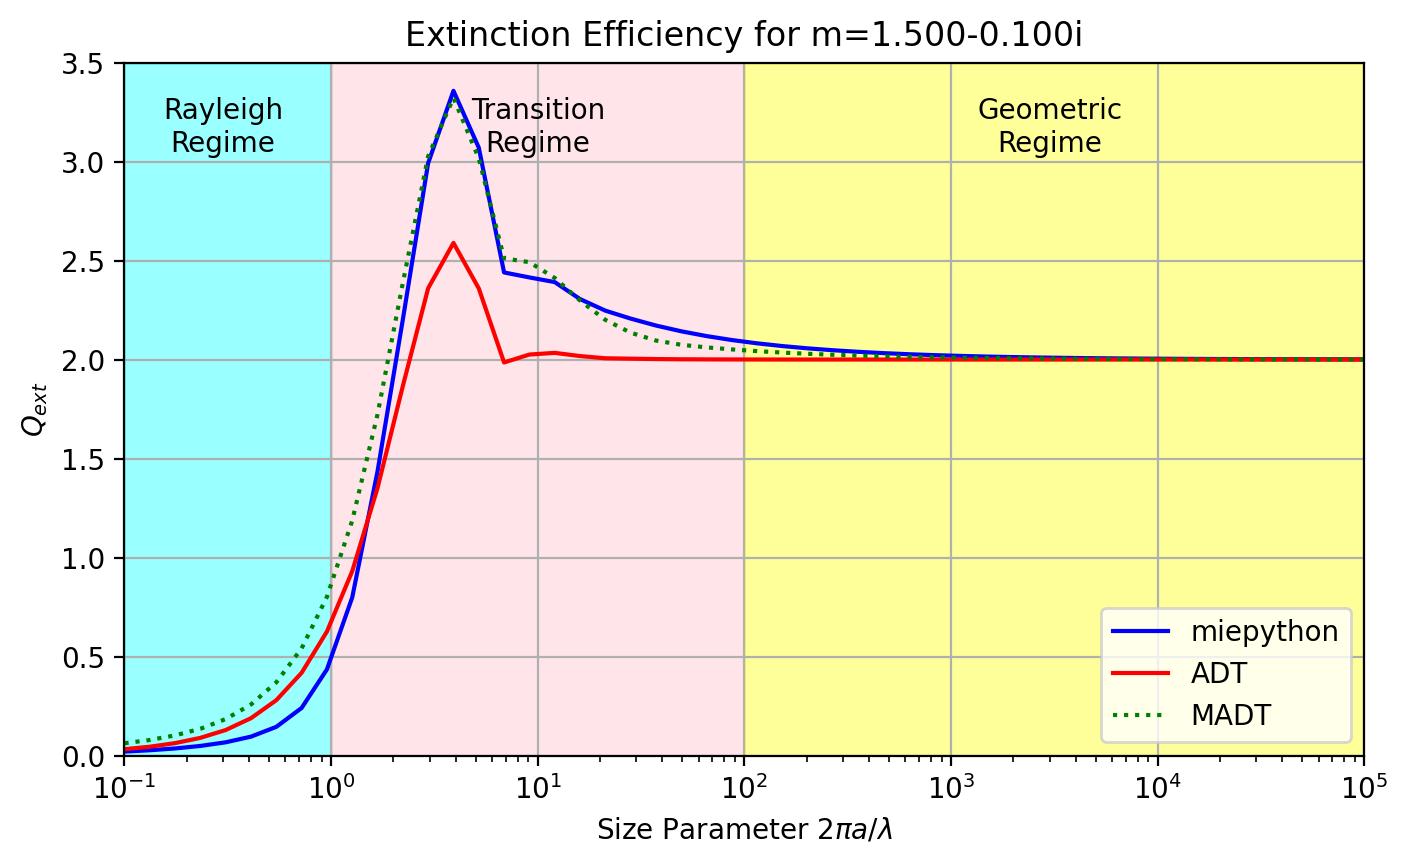

In [20]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, qext, 'b', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g:', label="MADT")

plt.ylabel("$Q_{ext}$")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(3.5)
plt.show()

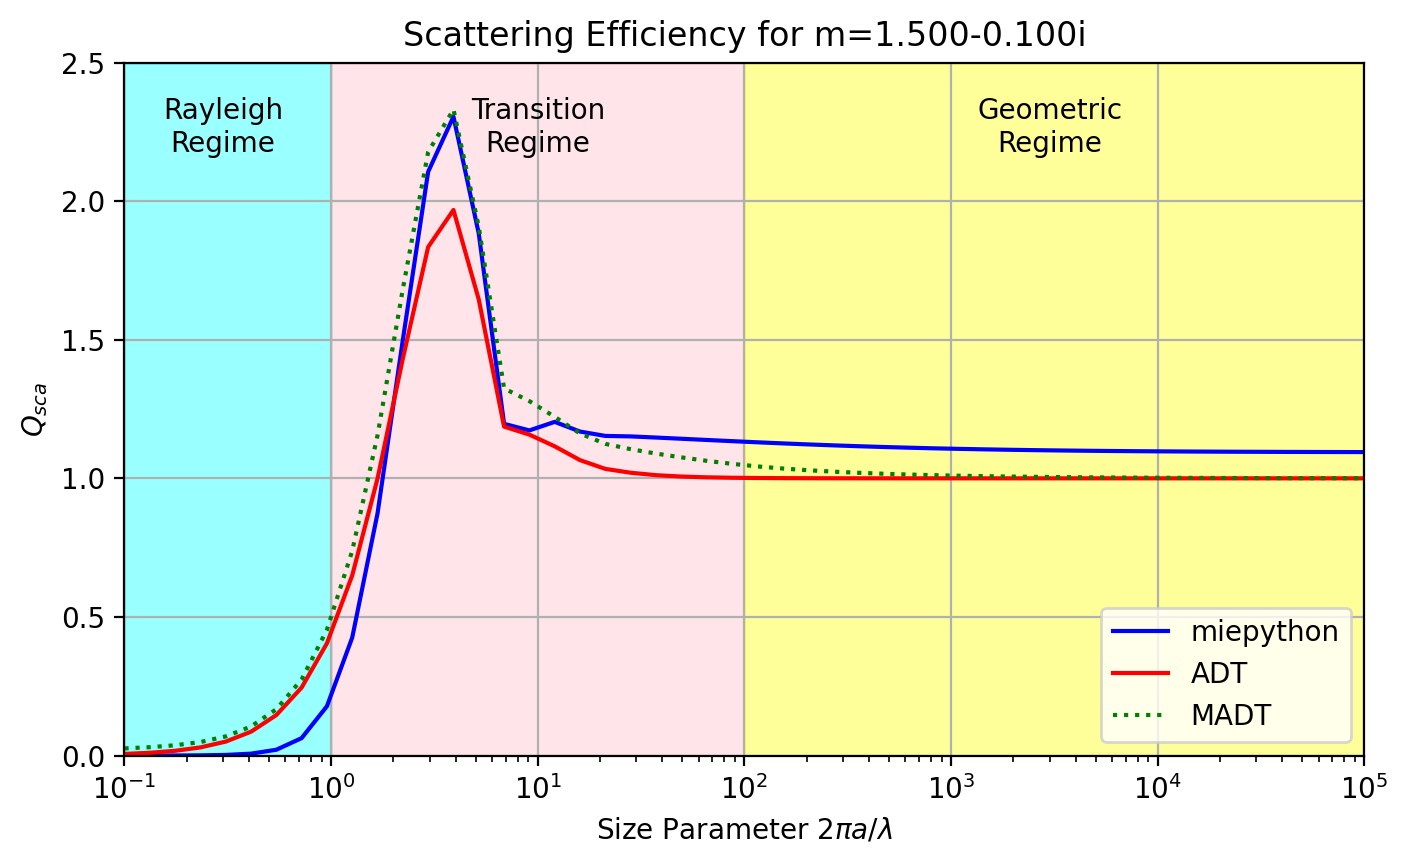

In [21]:
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)

plt.figure(figsize=(8,4.5))
plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r', label="ADT")
plt.semilogx(x, Qsca_madt, 'g:', label="MADT")

plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(2.5)
plt.ylim(0,2.5)
plt.show()

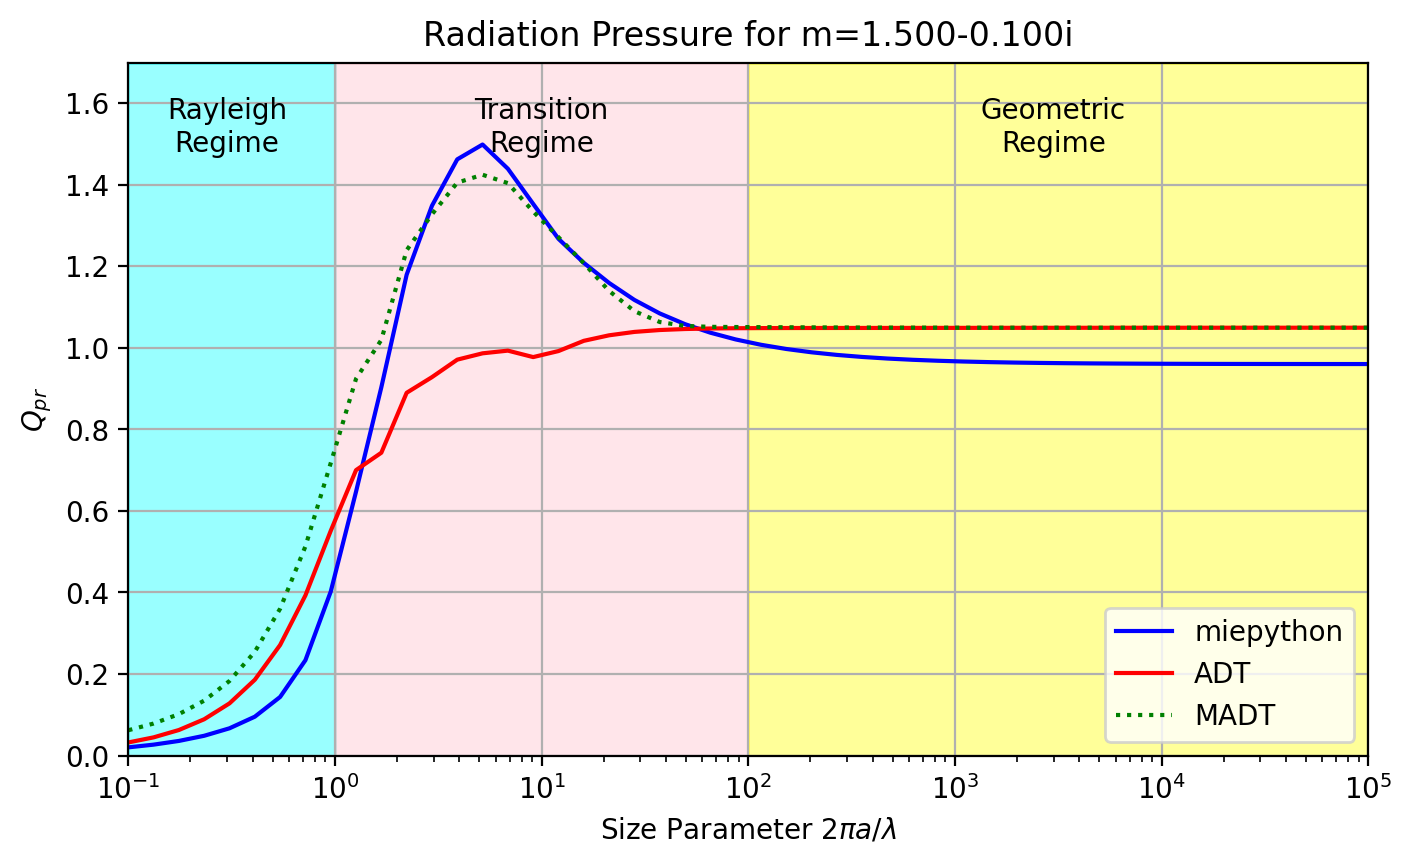

In [22]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.figure(figsize=(8,4.5))
plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r', label="ADT")
plt.semilogx(x, Qpr_madt, 'g:', label="MADT")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.7)
plt.show()

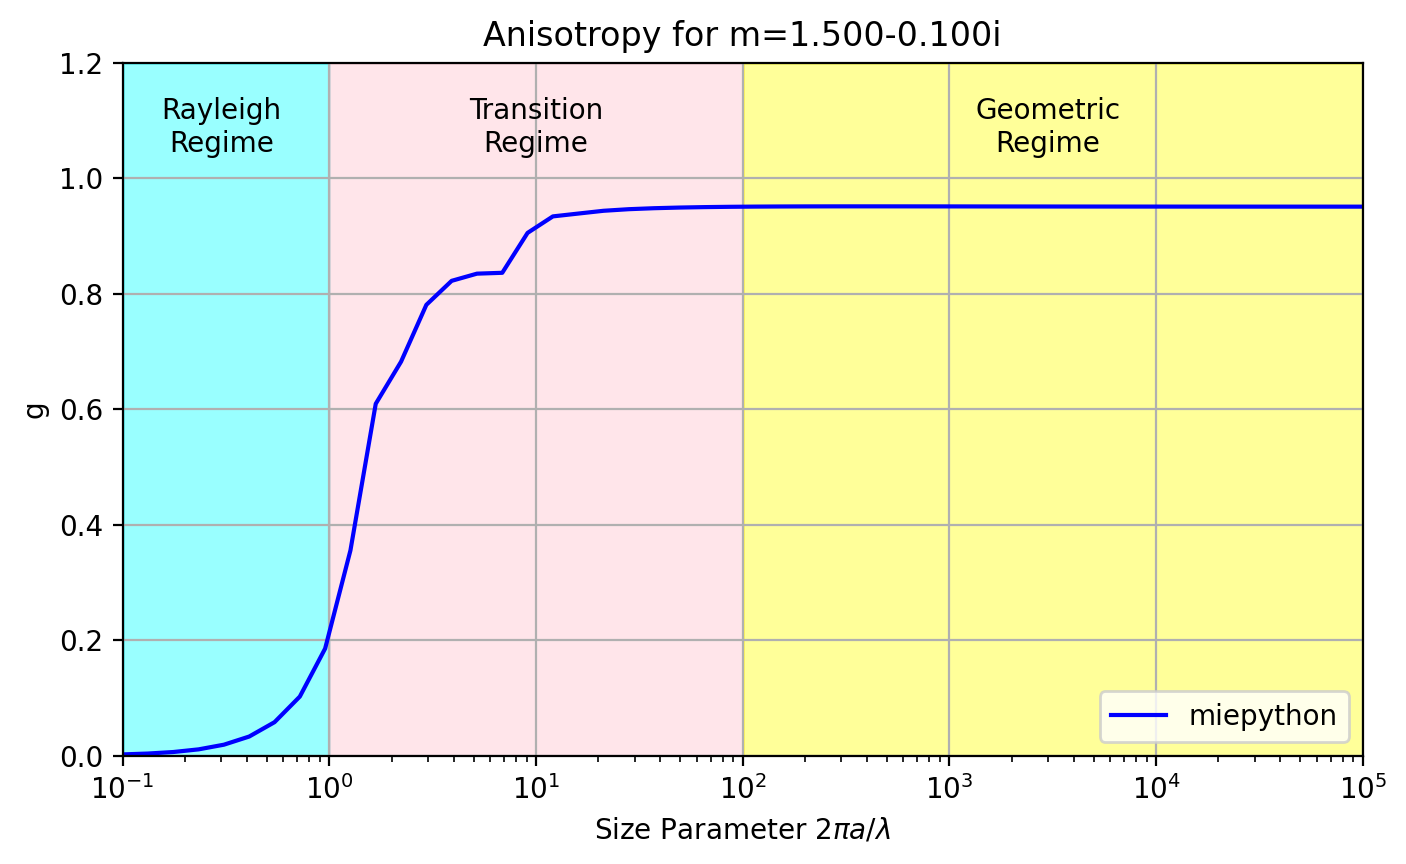

In [23]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, g, 'b', label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.2)
plt.show()

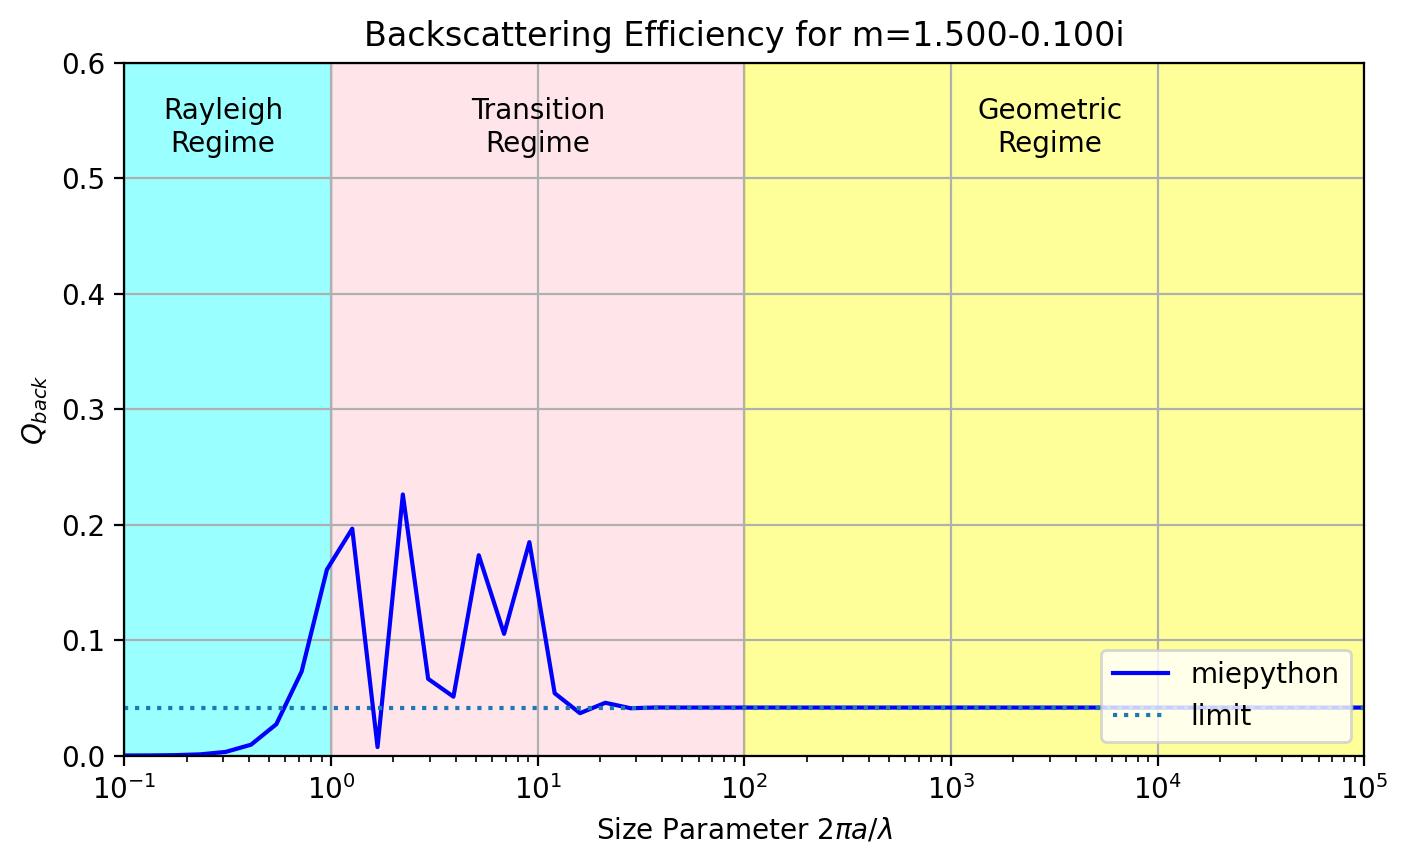

In [24]:
Qbacks = abs(m-1)**2/abs(m+1)**2
Qback = Qbacks * np.ones_like(x)

plt.figure(figsize=(8,4.5))
plt.semilogx(x, qback, 'b', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.ylabel("$Q_{back}$")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(0.6)

plt.show()

## A lot of absorption `m=1.5-1j`

In [25]:
m = 1.5-1j
x = np.logspace(-1, 5, 50)  # also in microns
qext, qsca, qback, g = miepython.mie(m,x)
qabs = qext-qsca

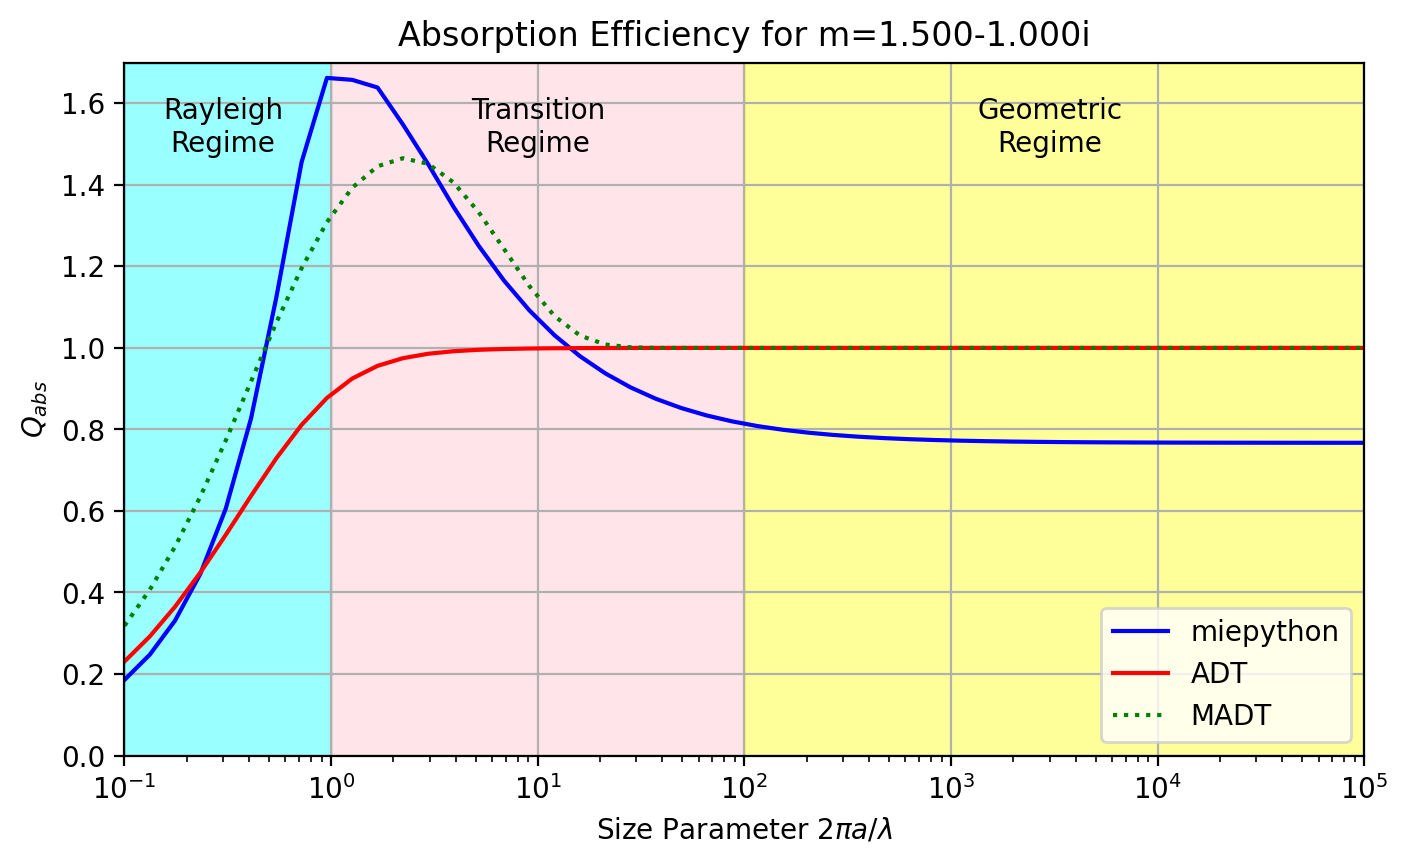

In [26]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, qabs, 'b', label="miepython")
plt.semilogx(x, Qabs_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qabs_madt(m,x), 'g:', label="MADT")

plt.ylabel("$Q_{abs}$")
plt.title("Absorption Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.7)
plt.show()

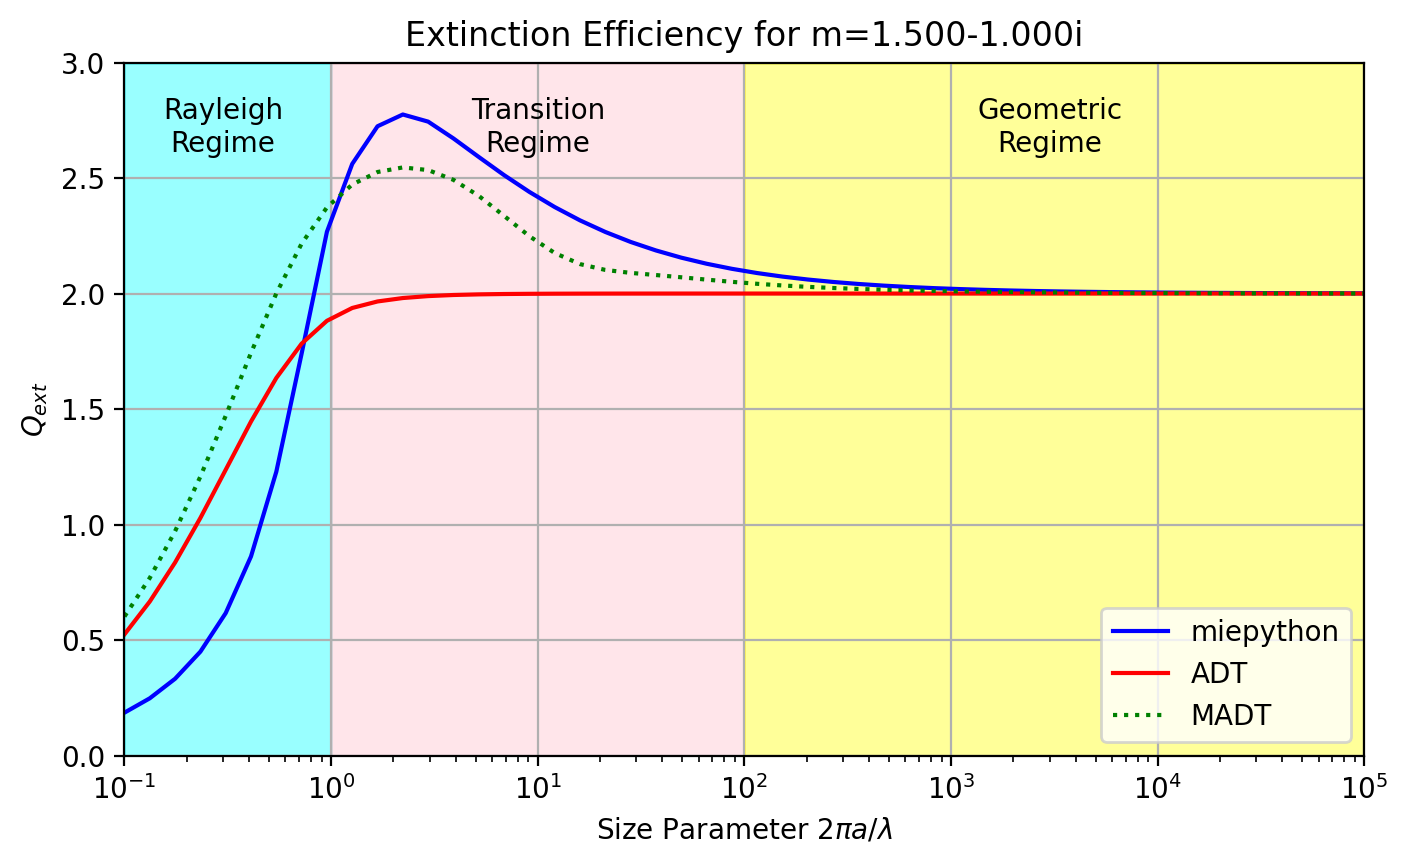

In [27]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, qext, 'b', label="miepython")
plt.semilogx(x, Qext_adt(m,x), 'r', label="ADT")
plt.semilogx(x, Qext_madt(m,x), 'g:', label="MADT")

plt.ylabel("$Q_{ext}$")
plt.title("Extinction Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(3)

plt.show()

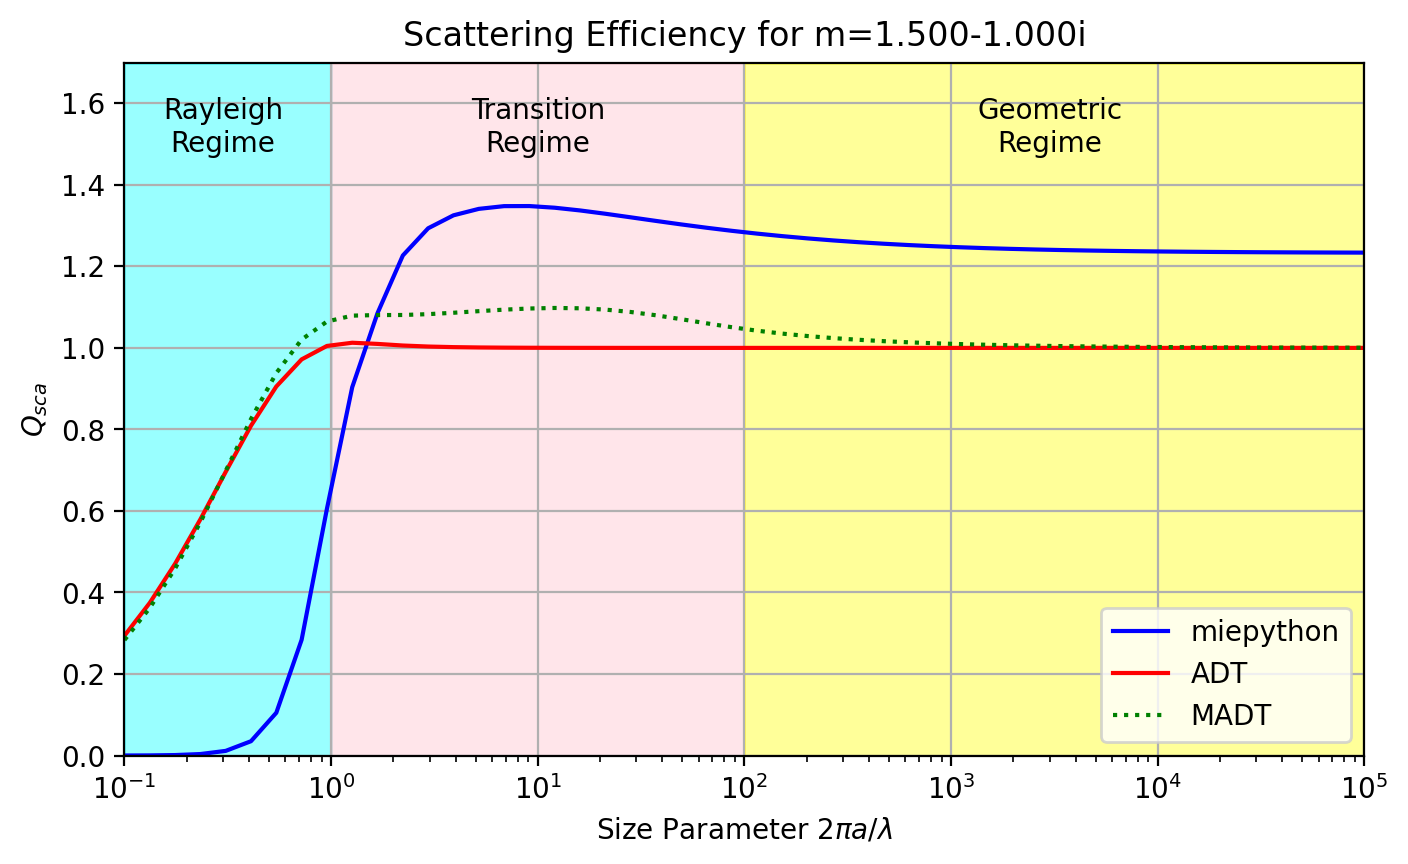

In [28]:
plt.figure(figsize=(8,4.5))
Qsca_adt = Qext_adt(m,x)-Qabs_adt(m,x)
Qsca_madt = Qext_madt(m,x)-Qabs_madt(m,x)
Qsca_geo = np.full_like(x,1 + abs((m-1)**2/(m+1)**2))

plt.semilogx(x, qsca, 'b', label="miepython")
plt.semilogx(x, Qsca_adt, 'r', label="ADT")
plt.semilogx(x, Qsca_madt, 'g:', label="MADT")

plt.ylabel("$Q_{sca}$")
plt.title("Scattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.7)

plt.show()

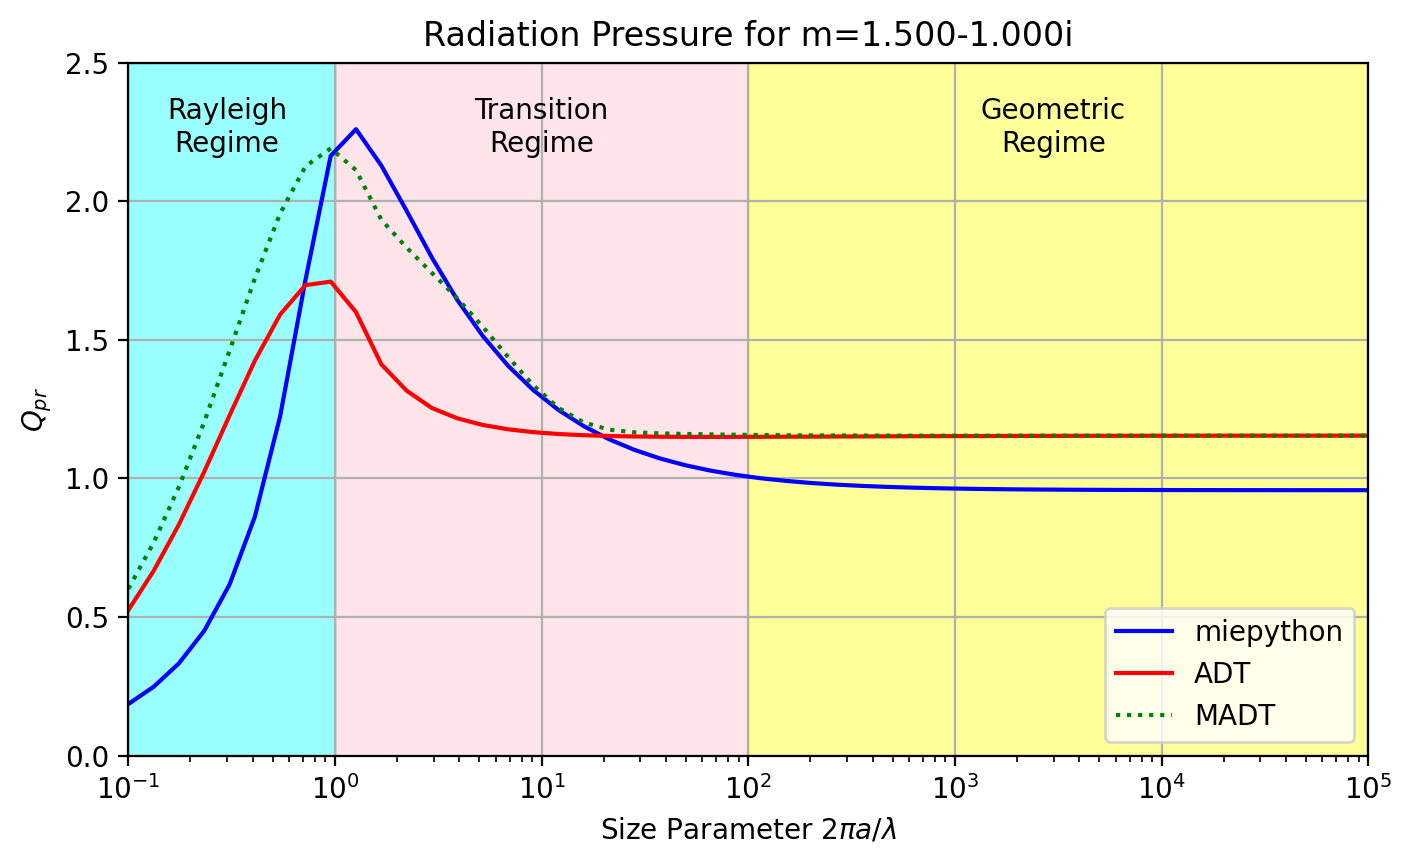

In [29]:
Qpr_adt = Qext_adt(m,x)-g*Qsca_adt
Qpr_madt = Qext_madt(m,x)-g*Qsca_madt

plt.figure(figsize=(8,4.5))
plt.semilogx(x, qext - g * qsca, 'b', label="miepython")
plt.semilogx(x, Qpr_adt, 'r', label="ADT")
plt.semilogx(x, Qpr_madt, 'g:', label="MADT")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{pr}$")
plt.title("Radiation Pressure for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(2.5)

plt.show()

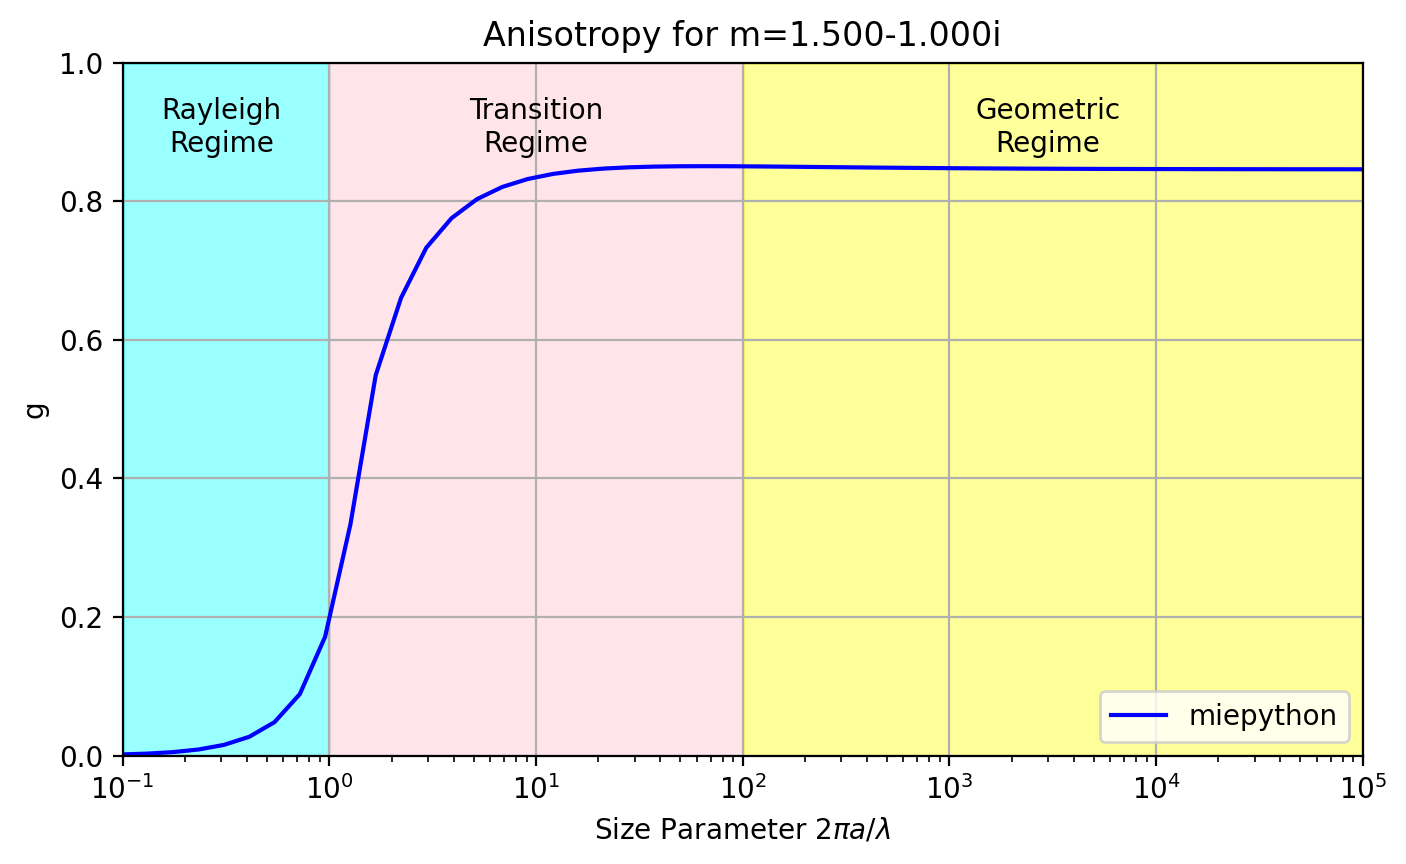

In [30]:
plt.figure(figsize=(8,4.5))
plt.semilogx(x, g, 'b', label="miepython")

plt.xlabel("Size Parameter")
plt.ylabel("g")
plt.title("Anisotropy for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(1.0)

plt.show()

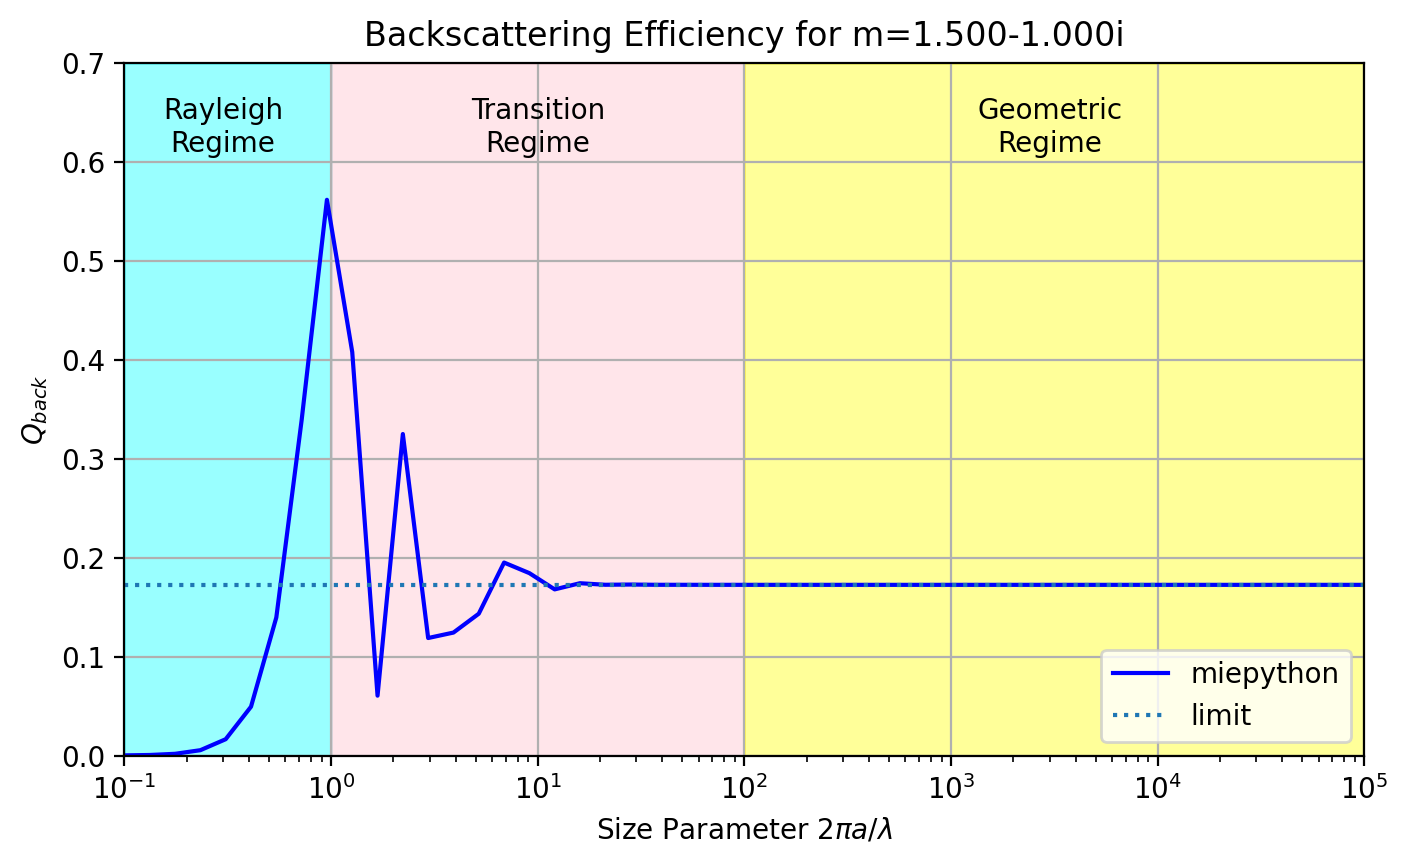

In [31]:
Qbacks = abs(m-1)**2/abs(m+1)**2
Qback = Qbacks * np.ones_like(x)

plt.figure(figsize=(8,4.5))
plt.semilogx(x, qback, 'b', label="miepython")
plt.semilogx(x, Qback, ':', label="limit")

plt.xlabel("Size Parameter")
plt.ylabel("$Q_{back}$")
plt.title("Backscattering Efficiency for m=%.3f-%.3fi" % (m.real,abs(m.imag)))
add_common_plot_stuff(0.7)

plt.show()